In [ ]:
""" Testing/Debugging File """

"""
Restart kernel after running
Only need to run once
"""
!pip install scikit-learn matplotlib seaborn

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.utils.data as td
import torch.nn as nn
import torch.nn.init as init
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import DataLoader, Dataset, Subset

froot = './data/k562_samp_epft_norm_test_1.csv'
df = pd.read_csv(froot)

print(df.head())

/grid/siepel/home_norepl/hassett/.local/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3553: DtypeWarning: Columns (0) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


  seqnames     start       end strand  ensembl_gene_id  score      ctcf  \
0       15  88623545  88623545      +  ENSG00000181026    0.0 -0.079992   
1       15  88623546  88623546      +  ENSG00000181026    0.0 -0.079942   
2       15  88623547  88623547      +  ENSG00000181026    0.0 -0.079893   
3       15  88623548  88623548      +  ENSG00000181026    0.0 -0.079844   
4       15  88623549  88623549      +  ENSG00000181026    0.0 -0.079796   

   h3k36me3   h3k4me1  h3k79me2   h3k9me1   h3k9me3  h4k20me1       sj5  \
0 -0.000099  0.348531  4.423451  0.446508 -0.168099  3.232475 -0.028916   
1  0.001638  0.352677  4.460072  0.453024 -0.169218  3.259194 -0.028916   
2  0.003360  0.356807  4.496664  0.459491 -0.170339  3.285849 -0.028916   
3  0.005065  0.360919  4.533223  0.465908 -0.171461  3.312435 -0.028916   
4  0.006754  0.365013  4.569743  0.472274 -0.172584  3.338952 -0.028916   

        sj3       dms  wgbs      rpts  lambda_alphaj      zeta  
0 -0.057178 -0.307549   0.0  0.24

In [3]:
column_names = np.array(df.columns)
feature_names = column_names[6:-2]
num_features = len(feature_names)
print(feature_names)
num_samples = df.shape[0]

# process read counts per gene j, site i
X_ji = df['score'].values

# process GLM simulated elongation rates
Z_ji = df['zeta'].values

print("Number of Samples: " + str(num_samples))
print("Number of Features: " + str(num_features))

#Y_ji is a list of samples containing lists of their feature values
    # [   
    #   sample_1: [feat_1, feat_2,...,feat_n],
    #   sample_2: [feat_1, feat_2,...,feat_n],
    # ]

Y_ji = df.iloc[:, 6:-2].values
Y_ji_shape = Y_ji.shape
print(Y_ji.shape)

# read depth * initiation rate values per gene j
C_j = df['lambda_alphaj'].values

gene_ids = df['ensembl_gene_id'].values

cuda_available = torch.cuda.is_available()
print("CUDA (GPU support) is available:", cuda_available)
num_gpus = torch.cuda.device_count()
print("Number of GPUs available:", num_gpus)

['ctcf' 'h3k36me3' 'h3k4me1' 'h3k79me2' 'h3k9me1' 'h3k9me3' 'h4k20me1'
 'sj5' 'sj3' 'dms' 'wgbs' 'rpts']
Number of Samples: 16182613
Number of Features: 12
(16182613, 12)
CUDA (GPU support) is available: True
Number of GPUs available: 1


In [28]:
class GeneDataset(Dataset):
    def __init__(self, grouped_data, use_sliding_window=False, window_size=None):
        self.grouped_data = grouped_data
        self.use_sliding_window = use_sliding_window
        self.window_size = window_size
        # store windows over sequences
        self.segments = []

        # use subsequence windows from genes
        if self.use_sliding_window and window_size is not None:
            self._create_segments()
        # use full-length genes
        else:
            self._prepare_full_genes()
    
    # create windows over sequences
    def _create_segments(self):
        for gene_id, group in self.grouped_data:
            gene_length = len(group)
            for start_idx in range(0, gene_length - self.window_size + 1, self.window_size):
                end_idx = start_idx + self.window_size
                segment = group.iloc[start_idx:end_idx]
                self.segments.append((gene_id, segment))
    
    def _prepare_full_genes(self):
        for gene_id, group in self.grouped_data:
            self.segments.append((gene_id, group))

    def __len__(self):
        return len(self.segments)

    # prepare single window or gene
    def __getitem__(self, idx):
        gene_id, segment = self.segments[idx]
        
        y_ji_array = np.array(segment['Y_ji'].tolist()).reshape(-1, 12)
        y_ji_tensor = torch.tensor(y_ji_array, dtype=torch.float64)
        
        data = segment.drop(columns=[col for col in ['GeneId', 'dataset', 'Y_ji'] if col in segment.columns])
        tensor_data = torch.tensor(data.values, dtype=torch.float64)
        
        result = {
            'GeneId': gene_id,
            'Y_ji': y_ji_tensor,
            'gene_length': len(segment)
        }
        for col in data.columns:
            result[col] = tensor_data[:, data.columns.get_loc(col)]

        return result

In [30]:
from torch.utils.data import BatchSampler

class GeneIdBatchSampler(BatchSampler):
    def __init__(self, dataset, drop_last=False):
        self.dataset = dataset
        self.drop_last = drop_last
        self.batches = self._create_batches()

    def _create_batches(self):
        # Group indices by GeneId
        gene_id_to_indices = {}
        for idx in range(len(self.dataset)):
            gene_id = self.dataset[idx]['GeneId']
            if gene_id not in gene_id_to_indices:
                gene_id_to_indices[gene_id] = []
            gene_id_to_indices[gene_id].append(idx)

        return list(gene_id_to_indices.values())

    def __iter__(self):
        for batch in self.batches:
            yield batch

    def __len__(self):
        return len(self.batches)

In [25]:
from sklearn.model_selection import train_test_split

data = pd.DataFrame({
    'GeneId': gene_ids,
    'Y_ji': [row for row in Y_ji],
    'X_ji': X_ji,
    'C_j': C_j,
    'Z_ji': Z_ji
})

# only keep genes divisble by 100
grouped = data.groupby('GeneId').filter(lambda x: len(x) % 100 == 0).groupby('GeneId')

# split by gene into train, val, test sets
train_idx, temp_idx = train_test_split(list(grouped.groups.keys()), test_size=0.2, random_state=42)
val_idx, test_idx = train_test_split(temp_idx, test_size=0.5, random_state=42)

# create dictionary mapping each gene id to its assigned train, val, test dataset labels
dataset_mapping = {gene_id: 'train' for gene_id in train_idx}
dataset_mapping.update({gene_id: 'val' for gene_id in val_idx})
dataset_mapping.update({gene_id: 'test' for gene_id in test_idx})

# filter rows based on assigned dataset field
data['dataset'] = data['GeneId'].map(dataset_mapping)
train_data = data[data['dataset'] == 'train']
valid_data = data[data['dataset'] == 'val']
test_data = data[data['dataset'] == 'test']

print("train data size: " + str(len(train_data)))
print("val data size: " + str(len(valid_data)))
print("test data size: " + str(len(test_data)))

train_data = train_data.groupby('GeneId')
valid_data = valid_data.groupby('GeneId')
test_data = test_data.groupby('GeneId')
print("train # genes: " + str(len(train_data)))
print("val # genes: " + str(len(valid_data)))
print("test # genes: " + str(len(test_data)))

train data size: 5924800
val data size: 906000
test data size: 660000
train # genes: 320
val # genes: 40
test # genes: 41


In [47]:
def build_dataset(train_data, use_sliding_window=False, window_size=None):
    dataset = GeneDataset(train_data, use_sliding_window, window_size)
    batch_sampler = GeneIdBatchSampler(dataset)
    loader = DataLoader(dataset, batch_sampler=batch_sampler, shuffle=False, num_workers=7, pin_memory=True)
    return loader

In [79]:
import math 

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def build_model(model_type, num_lstm_layers, lstm_hidden_layer_size, bidirectional, 
                dense_hidden_layer_sizes, dense_activation_func, hidden_dc_mlp_size, 
                hidden_dc_cnn_sizes, filter_size, pool_size, dropout, window_size, weight_init):
    
    class LSTMModel(nn.Module):
        def __init__(self, input_size, hidden_layer_size, output_size, num_layers, bidirectional):
            super(LSTMModel, self).__init__()
            self.lstm = nn.LSTM(input_size, hidden_layer_size, num_layers, bidirectional=bidirectional, batch_first=True)
            self.bidirectional_linear = nn.Linear(2 * hidden_layer_size, output_size)
            self.linear = nn.Linear(hidden_layer_size, output_size)
            self.bidirectional = bidirectional

        def forward(self, x):
            x, _ = self.lstm(x)
            if self.bidirectional:
                x = self.bidirectional_linear(x)
            else:
                x = self.linear(x)
            return x
        
    class DenseNet(nn.Module):
        def __init__(self, input_size, layer_sizes, output_size, activation='relu'):
            super(DenseNet, self).__init__()
            
            layers = []

            # Define the input layer
            prev_size = input_size

            for size in layer_sizes:
                layers.append(nn.Linear(prev_size, size))

                if activation.lower() == 'leakyrelu':
                    layers.append(nn.LeakyReLU())
                elif activation.lower() == 'relu':
                    layers.append(nn.ReLU())
                else:
                    raise ValueError("Unsupported activation function")

                prev_size = size

            layers.append(nn.Linear(prev_size, output_size))

            self.layers = nn.Sequential(*layers)

        def forward(self, x):
            return self.layers(x)
        
    class DeepChromeMLP(nn.Module): # input_size = num_features * width (width = 100)
        def __init__(self, input_size, hidden_dc_mlp_size):
            super(DeepChromeMLP, self).__init__()
            self.linear1 = nn.Linear(input_size, hidden_dc_mlp_size)
            self.tanh = nn.Tanh()
            self.linear2 = nn.Linear(hidden_dc_mlp_size, 1)

        def forward(self, x):
            x = self.linear1(x)
            x = self.tanh(x)
            x = self.linear2(x)
            return x

    class DeepChromeCNN(nn.Module): 
        def __init__(self, input_size, hidden_dc_cnn_sizes, filter_size, pool_size, dropout, window_size):
            super(DeepChromeCNN, self).__init__()
            self.conv1d = nn.Conv1d(input_size, hidden_dc_cnn_sizes[0], filter_size)
            self.relu = nn.ReLU()
            self.maxpool1d = nn.MaxPool1d(pool_size)
            
            self.dropout = nn.Dropout(dropout)
            self.linear1_input_size = math.ceil((window_size-filter_size)/pool_size)*hidden_dc_cnn_sizes[0]
            self.linear1 = nn.Linear(self.linear1_input_size, hidden_dc_cnn_sizes[1])
            self.linear2 = nn.Linear(hidden_dc_cnn_sizes[1], hidden_dc_cnn_sizes[2])
            self.linear3 = nn.Linear(hidden_dc_cnn_sizes[2], window_size)
            

        def forward(self, x):
            x = x.permute(0, 2, 1)
            x = self.conv1d(x)
            x = self.relu(x)
            x = self.maxpool1d(x)
            
            x = x.view(-1, self.linear1_input_size)
            x = self.dropout(x)
            x = self.linear1(x)
            x = self.relu(x)
            x = self.linear2(x)
            x = self.relu(x)
            x = self.linear3(x)
            
            return x
    
    if model_type == 'lstm':
        model = LSTMModel(num_features, lstm_hidden_layer_size, 1, num_lstm_layers, bidirectional)
    elif model_type == 'linear':
        model = nn.Linear(num_features, 1, bias=False)
    elif model_type == 'dense':
        model = DenseNet(num_features, dense_hidden_layer_sizes, 1, dense_activation_func)
    elif model_type == 'dc_mlp':
        model = DeepChromeMLP(num_features, hidden_dc_mlp_size)
    elif model_type == 'dc_cnn':
        model = DeepChromeCNN(num_features, hidden_dc_cnn_sizes, filter_size, pool_size, dropout, window_size)
        
    
    if cuda_available:
        if num_gpus > 1:
            print("Using", num_gpus, "GPUs")
            model = torch.nn.DataParallel(model)
        model = model.to('cuda')

    print(model)
    
    """
    # print # model parameters
    arr = torch.randn((1,12,2000)).to(device)
    print(model(arr).shape)
    nparm = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print("Number of parameters: " + str(nparm))
    """

    first_param_device = next(model.parameters()).device
    print("Model is on device:", first_param_device)
    
    # expected weights are close to 0 which is why 0 initializing weights converges much quicker
    if weight_init == 'zero':
        with torch.no_grad():
            for param in model.parameters():
                param.zero_()
    
    model.double()

    return model.to(device)

In [80]:
def build_optimizer(network, optimizer, learning_rate, momentum):
    if optimizer == "sgd":
        optimizer = optim.SGD(network.parameters(),
                              lr=learning_rate, momentum=momentum)
        
    # Adam optimizer adapts the learning rate for each parameter individually
    elif optimizer == "adam":
        optimizer = optim.Adam(network.parameters(),
                               lr=learning_rate)
    return optimizer

In [88]:
def valid_epoch(model, loader, loss_fn):
    model.eval()
    total_neural_net_loss = 0
    total_glm_loss = 0
    neural_net_zeta = []
    glm_zeta = []
    
    with torch.no_grad():
        for idx, batch in enumerate(loader):
            Y_ji_batch = batch['Y_ji'].to(device)
            X_ji_batch = batch['X_ji'].to(device)
            C_j_batch = batch['C_j'].to(device)
            Z_ji_batch = batch['Z_ji'].to(device)
            lengths = batch['gene_length'].to(device)
            
            outputs = model(Y_ji_batch)
            neural_net_loss = loss_fn(X_ji_batch, C_j_batch, outputs.squeeze(2), lengths) # remove outputs.squeeze(2) for cnn
            glm_loss = loss_fn(X_ji_batch, C_j_batch, Z_ji_batch, lengths)

            total_neural_net_loss +=  neural_net_loss.item()
            total_glm_loss += glm_loss.item()
            
            # store all predictions in list
            neural_net_zeta.append(torch.exp(outputs.cpu()[0]))
            glm_zeta.append(batch['Z_ji'][0])
    
    # calculate average loss across all batches
    avg_neural_net_loss = total_neural_net_loss / len(loader)
    avg_glm_loss = total_glm_loss / len(loader)
    
    neural_net_zeta = torch.cat(neural_net_zeta, dim=0)
    glm_zeta = torch.cat(glm_zeta, dim=0)
    
    return avg_neural_net_loss, avg_glm_loss, neural_net_zeta, glm_zeta

In [89]:
def train_epoch(model, loader, optimizer, loss_fn):
    model.train()
    total_loss = 0
    for idx, batch in enumerate(loader):
        optimizer.zero_grad()
        Y_ji_batch = batch['Y_ji'].to(device) 
        X_ji_batch = batch['X_ji'].to(device)
        C_j_batch = batch['C_j'].to(device)
        lengths = batch['gene_length'].to(device)
        
        outputs = model(Y_ji_batch)
        loss = loss_fn(X_ji_batch, C_j_batch, outputs.squeeze(2), lengths) # remove outputs.squeeze(2) for cnn
        loss.backward()
        optimizer.step()
        
        # calculate average loss across all batches
        total_loss += loss.item()
    avg_train_loss = total_loss / len(loader)
    
    return avg_train_loss

In [90]:
class CustomLoss(nn.Module):
    def __init__(self):
        super(CustomLoss, self).__init__()

    def forward(self, X_ji, C_j, rho_ji, lengths):
        C_j_value = C_j[0]
        loss = X_ji * rho_ji + C_j_value * torch.exp(-rho_ji) - X_ji * torch.log(C_j_value)
        
        # normalize loss by sequence length
        loss_sum = loss.sum(dim=1)
        normalized_loss = loss_sum / lengths.float()
        
        # calculate average loss within each batch
        return (normalized_loss).mean()

In [91]:
def print_profiler_results(profiler):
    # Sort by CUDA memory usage if using CUDA, else sort by CPU memory usage
    sort_by_key = "cuda_memory_usage" if torch.cuda.is_available() else "cpu_memory_usage"
    print(profiler.key_averages().table(sort_by=sort_by_key, row_limit=10))

In [92]:
model_type = 'lstm'#'dc_cnn'

# lstm configs
num_lstm_layers = 2
lstm_hidden_layer_size = 100
bidirectional = True

# dense configs
dense_hidden_layer_sizes = [6] 
dense_activation_func = 'relu'

# deep chrome mlp configs
hidden_dc_mlp_size = 6

# deep chrome cnn configs
hidden_dc_cnn_sizes = [50, 625, 125]
filter_size = 10
pool_size = 5
dropout = 0.5

weight_init = None#'zero'

# dataset configs
train_use_sliding_window = True
train_window_size = 100
val_use_sliding_window = True
val_window_size = 100

# optimizer configs
learning_rate = 1e-3
optimizer_type = 'sgd'
momentum = 0

In [95]:
from torch.optim.lr_scheduler import ReduceLROnPlateau
epochs = 20

def train():
    model = build_model(model_type, num_lstm_layers, lstm_hidden_layer_size, bidirectional,
                        dense_hidden_layer_sizes, dense_activation_func, hidden_dc_mlp_size, hidden_dc_cnn_sizes, 
                        filter_size, pool_size, dropout, train_window_size, weight_init)
    train_loader = build_dataset(train_data, train_use_sliding_window, train_window_size) # if window size = stride, then no data overlap
    valid_loader = build_dataset(valid_data, val_use_sliding_window, val_window_size)
    optimizer = build_optimizer(model, optimizer_type, learning_rate, momentum)
    
    loss_fn = CustomLoss()
    # track loss curves
    loss_neural_net_train = [0] * epochs
    loss_neural_net_valid = [0] * epochs
    loss_glm_valid = [0] * epochs
    
    # scheduler to reduce learning rate by half when new validation loss > old validation loss
    old_train_loss = float('inf')
    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=1, verbose=True)

    for epoch in range(epochs):
        print(f'Epoch {epoch+1}')
        
        train_loss = train_epoch(model, train_loader, optimizer, loss_fn)
        loss_neural_net_train[epoch] = train_loss
        print("train loss: "+ str(train_loss))
        
        valid_neural_net_loss, valid_glm_loss, neural_net_zeta, glm_zeta = valid_epoch(model, valid_loader, loss_fn)
        loss_neural_net_valid[epoch] = valid_neural_net_loss
        loss_glm_valid[epoch] = valid_glm_loss
        print("valid neural net loss: "+ str(valid_neural_net_loss))
        print("valid glm loss: "+ str(valid_glm_loss))
        
        # compute metrics
        mae = F.l1_loss(neural_net_zeta.squeeze(), glm_zeta)
        mse = F.mse_loss(neural_net_zeta.squeeze(), glm_zeta)
        correlation_coefficient = np.corrcoef(glm_zeta, neural_net_zeta.squeeze())[0, 1]
        print("Correlation Coefficient:", correlation_coefficient)
        print(f"Mean Absolute Error: {mae.item():.4f}")
        print(f"Mean Squared Error: {mse.item():.4f}")
        
        # reduce learning rate if new loss > old loss
        if train_loss > old_train_loss:
            optimizer.param_groups[0]['lr'] *= 0.5
            print(f"Reduced learning rate to {optimizer.param_groups[0]['lr']}")
        old_train_loss = train_loss
        scheduler.step(train_loss)
        
    return model

In [94]:
model = train()

LSTMModel(
  (lstm): LSTM(12, 100, num_layers=2, batch_first=True, bidirectional=True)
  (bidirectional_linear): Linear(in_features=200, out_features=1, bias=True)
  (linear): Linear(in_features=100, out_features=1, bias=True)
)
Model is on device: cuda:0
Epoch 1


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


train loss: 0.13742259936342868


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


valid neural net loss: 0.13751576405837349
valid glm loss: 0.14974426882096437
Correlation Coefficient: 0.655301409628589
Mean Absolute Error: 0.1397
Mean Squared Error: 0.0307
Epoch 2


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


train loss: 0.13741293324886977


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warn

valid neural net loss: 0.13750759397322673
valid glm loss: 0.14974426882096437
Correlation Coefficient: 0.6600268684809527
Mean Absolute Error: 0.1398
Mean Squared Error: 0.0307
Epoch 3


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


train loss: 0.13740346539491513


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


valid neural net loss: 0.13749960823798085
valid glm loss: 0.14974426882096437
Correlation Coefficient: 0.6645858016370728
Mean Absolute Error: 0.1400
Mean Squared Error: 0.0307
Epoch 4


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


train loss: 0.1373941901700426


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


valid neural net loss: 0.1374918013765769
valid glm loss: 0.14974426882096437
Correlation Coefficient: 0.6689856942543859
Mean Absolute Error: 0.1401
Mean Squared Error: 0.0307
Epoch 5


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


train loss: 0.13738510208583551


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


valid neural net loss: 0.13748416806055777
valid glm loss: 0.14974426882096437
Correlation Coefficient: 0.6732336514091694
Mean Absolute Error: 0.1403
Mean Squared Error: 0.0307
Epoch 6


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


train loss: 0.1373761957953031


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


valid neural net loss: 0.1374767031063186
valid glm loss: 0.14974426882096437
Correlation Coefficient: 0.6773364174325932
Mean Absolute Error: 0.1404
Mean Squared Error: 0.0307
Epoch 7


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


train loss: 0.13736746609206327


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


valid neural net loss: 0.13746940147245232
valid glm loss: 0.14974426882096437
Correlation Coefficient: 0.6813003945383949
Mean Absolute Error: 0.1405
Mean Squared Error: 0.0307
Epoch 8


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


train loss: 0.13735890790932792


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


valid neural net loss: 0.13746225825695463
valid glm loss: 0.14974426882096437
Correlation Coefficient: 0.6851316607225129
Mean Absolute Error: 0.1407
Mean Squared Error: 0.0307
Epoch 9


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


train loss: 0.1373505163181426


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


valid neural net loss: 0.137455268694237
valid glm loss: 0.14974426882096437
Correlation Coefficient: 0.6888359869034221
Mean Absolute Error: 0.1408
Mean Squared Error: 0.0307
Epoch 10


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


train loss: 0.13734228652488895


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


valid neural net loss: 0.1374484281520018
valid glm loss: 0.14974426882096437
Correlation Coefficient: 0.6924188532806215
Mean Absolute Error: 0.1409
Mean Squared Error: 0.0307
Epoch 11


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


train loss: 0.13733421386830194


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


valid neural net loss: 0.13744173212805397
valid glm loss: 0.14974426882096437
Correlation Coefficient: 0.6958854649048349
Mean Absolute Error: 0.1411
Mean Squared Error: 0.0307
Epoch 12


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


train loss: 0.1373262938162508


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


valid neural net loss: 0.13743517624710083
valid glm loss: 0.14974426882096437
Correlation Coefficient: 0.6992407664675647
Mean Absolute Error: 0.1412
Mean Squared Error: 0.0308
Epoch 13


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


train loss: 0.1373185219624412


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


valid neural net loss: 0.1374287562575755
valid glm loss: 0.14974426882096437
Correlation Coefficient: 0.7024894563273126
Mean Absolute Error: 0.1413
Mean Squared Error: 0.0308
Epoch 14


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


train loss: 0.13731089402313065


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


valid neural net loss: 0.1374224680285035
valid glm loss: 0.14974426882096437
Correlation Coefficient: 0.705635999795985
Mean Absolute Error: 0.1414
Mean Squared Error: 0.0308
Epoch 15


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


train loss: 0.137303405833909


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


valid neural net loss: 0.13741630754643314
valid glm loss: 0.14974426882096437
Correlation Coefficient: 0.7086846417130829
Mean Absolute Error: 0.1416
Mean Squared Error: 0.0308
Epoch 16


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


train loss: 0.1372960533465864


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


valid neural net loss: 0.13741027091244257
valid glm loss: 0.14974426882096437
Correlation Coefficient: 0.7116394183378885
Mean Absolute Error: 0.1417
Mean Squared Error: 0.0309
Epoch 17


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


train loss: 0.13728883262621033


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


valid neural net loss: 0.13740435433923165
valid glm loss: 0.14974426882096437
Correlation Coefficient: 0.7145041685912931
Mean Absolute Error: 0.1418
Mean Squared Error: 0.0309
Epoch 18


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


train loss: 0.13728173984821382


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


valid neural net loss: 0.1373985541482899
valid glm loss: 0.14974426882096437
Correlation Coefficient: 0.7172825446790768
Mean Absolute Error: 0.1419
Mean Squared Error: 0.0309
Epoch 19


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


train loss: 0.13727477129564697


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


valid neural net loss: 0.13739286676712018
valid glm loss: 0.14974426882096437
Correlation Coefficient: 0.7199780221274585
Mean Absolute Error: 0.1420
Mean Squared Error: 0.0310
Epoch 20


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


train loss: 0.1372679233564136


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


valid neural net loss: 0.13738728872648218
valid glm loss: 0.14974426882096437
Correlation Coefficient: 0.7225939092599857
Mean Absolute Error: 0.1421
Mean Squared Error: 0.0310


In [ ]:
# save model parameters

from datetime import datetime

"""
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
filename = f"models/LSTM_Elongation_Model.pth"
torch.save(model.state_dict(), filename)
"""

In [ ]:
# load model state

"""
model = build_model(model_type, num_layers, hidden_layer_size, bidirectional, weight_init)

model.load_state_dict(torch.load("models/Elongation_Model.pth"))

cuda_available = torch.cuda.is_available()
print("CUDA (GPU support) is available:", cuda_available)
num_gpus = torch.cuda.device_count()
print("Number of GPUs available:", num_gpus)
if cuda_available:
    if num_gpus > 1:
        print("Using", num_gpus, "GPUs")
        model = torch.nn.DataParallel(model)
    model = model.to('cuda')

first_param_device = next(model.parameters()).device
print("Model is on device:", first_param_device)

model.double()
"""

In [101]:
weights = model.weight.data.cpu().numpy()
combined = ', '.join([f'"{s}": {f}' for s, f in zip(feature_names, weights[0])])
print(combined)

"ctcf": 0.0031987207283796625, "h3k36me3": -0.12421152667978225, "h3k4me1": -0.021062086373569593, "h3k79me2": -0.0389832792639541, "h3k9me1": -0.05266693797386992, "h3k9me3": -0.026519421964241254, "h4k20me1": -0.027763096636773142, "sj5": -0.018723344581300327, "sj3": -0.04029743818548164, "dms": -0.07932229215236103, "wgbs": -0.16842686394812184, "rpts": 0.020859243197197813


In [ ]:
glm_kappa = [-0.0224536145637661, -0.094592589, -0.023815382, 0.030402922, -0.067234092, -0.032196914, -0.040911478, -0.018557168, -0.033545905, -0.051103287, -0.204434712, 0.015831043]

In [ ]:
"""
GLM K

* ctcf: -0.02
* h3k36me3: -0.09
* h3k4me1: -0.02
* h3k79me2: +0.03
* h3k9me1: -0.06
* h3k9me3: -0.03
* h4k20me1: -0.04
* sj5: -0.02
* sj3: -0.03
* dms->stem-loop: -0.05
* rpts->low-complex: +0.01
* wgbs->DNAm: -0.2
"""

In [ ]:
# plot loss curve

epochs = range(1, len(loss_neural_net_train) + 1)
plt.plot(epochs, loss_neural_net_train, label='train_neural_net_loss')
plt.plot(epochs, loss_neural_net_valid, label='valid_neural_net_loss')
plt.plot(epochs, loss_glm_valid, label='valid_glm_loss')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show 

In [83]:
def plot_data(glm_zeta, net_zeta):
    indices = range(len(glm_zeta))
    
    fig, ax = plt.subplots(figsize=(10, 5))
    
    ax.scatter(indices, net_zeta, color='blue', label='Neural Net Zeta', s=10, alpha=0.5)
    ax.scatter(indices, glm_zeta, color='orange', label='GLM Zeta', s=10, alpha=0.5)
    
    ax.set_title('Neural Net vs GLM Elongation Rate')
    ax.set_xlabel('Index')
    ax.set_ylabel('Elongation Rate')
    ax.legend()
    
    plt.ylim(0.5, 1.3)

    plt.show()


number of samples: 6
tensor([[ 0.0206,  0.0008, -0.0298, -0.0741,  0.1145,  0.1141,  0.0812,  0.0911,
          0.0011, -0.1287,  0.0567, -0.1533,  0.0666, -0.0285, -0.0089, -0.0343,
         -0.0869, -0.0504,  0.0421,  0.0154, -0.0358,  0.0693,  0.0088,  0.0549,
         -0.0198, -0.0606, -0.1107,  0.0419, -0.0455, -0.0431, -0.0802,  0.0321,
          0.0887, -0.0550, -0.0277, -0.0397,  0.0165,  0.0012, -0.0874,  0.0392,
          0.0606,  0.0757, -0.1266, -0.0505,  0.0905,  0.1274,  0.0304,  0.0566,
         -0.0386, -0.0277, -0.0394, -0.0454,  0.0511,  0.0216, -0.0055,  0.0220,
          0.0466, -0.0136,  0.0547, -0.0206, -0.0673,  0.0942, -0.0356, -0.0805,
         -0.0242, -0.0668, -0.0707,  0.0793, -0.0176, -0.0143, -0.0701, -0.0307,
          0.1365,  0.0434,  0.1301,  0.0749, -0.0676, -0.0477,  0.0938, -0.0325,
          0.0542,  0.2004, -0.0093,  0.0076,  0.0313,  0.1411, -0.0311, -0.1078,
         -0.0317, -0.0004, -0.0796,  0.0787,  0.1240, -0.0312, -0.0189, -0.0709,
       

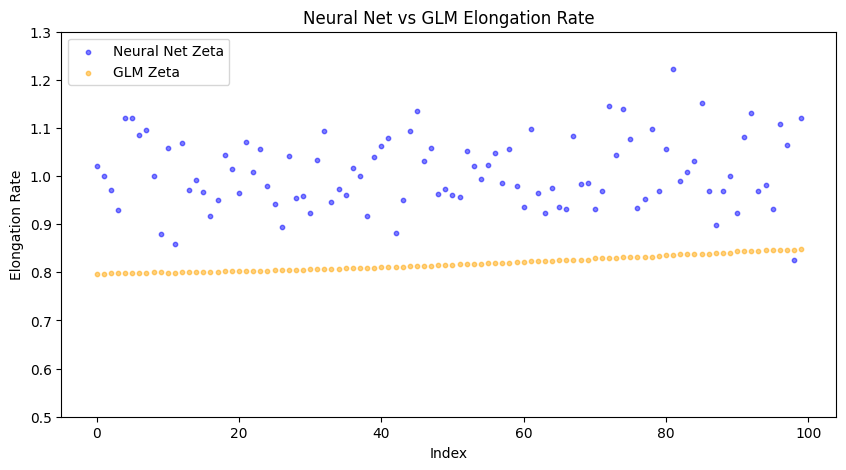

number of samples: 6
tensor([[ 0.0160, -0.0017, -0.0088, -0.0661,  0.1278,  0.0917,  0.0725,  0.0830,
          0.0040, -0.1037,  0.0600, -0.1449,  0.0691, -0.0326, -0.0029, -0.0324,
         -0.0932, -0.0625,  0.0355,  0.0178, -0.0326,  0.0657,  0.0062,  0.0611,
         -0.0068, -0.0529, -0.1012,  0.0388, -0.0362, -0.0458, -0.0658,  0.0422,
          0.0830, -0.0427, -0.0216, -0.0353,  0.0183, -0.0017, -0.0782,  0.0222,
          0.0614,  0.0660, -0.1206, -0.0427,  0.0853,  0.1174,  0.0219,  0.0655,
         -0.0162, -0.0238, -0.0443, -0.0485,  0.0545,  0.0344,  0.0029,  0.0194,
          0.0299, -0.0199,  0.0388, -0.0265, -0.0547,  0.0890, -0.0195, -0.0878,
         -0.0428, -0.0697, -0.0674,  0.0760, -0.0079, -0.0063, -0.0595, -0.0184,
          0.1275,  0.0484,  0.1176,  0.0728, -0.0749, -0.0435,  0.0802, -0.0267,
          0.0510,  0.1816,  0.0045, -0.0078,  0.0400,  0.1225, -0.0345, -0.0872,
         -0.0210,  0.0144, -0.0750,  0.0778,  0.1146, -0.0376, -0.0025, -0.0694,
       

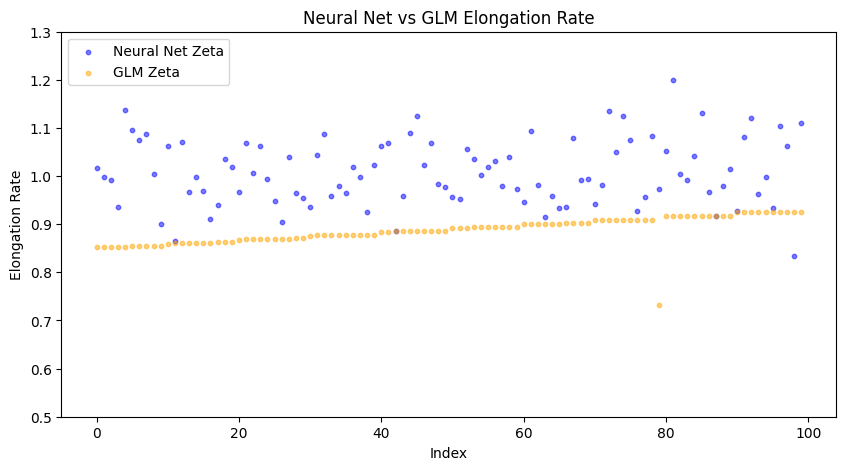

number of samples: 6
tensor([[-0.0026, -0.0143,  0.0110, -0.0590,  0.1257,  0.0690,  0.0703,  0.0714,
          0.0082, -0.0696,  0.0487, -0.1182,  0.0711, -0.0478,  0.0246, -0.0254,
         -0.0950, -0.0637,  0.0215,  0.0228, -0.0066,  0.0539,  0.0084,  0.0748,
          0.0035, -0.0487, -0.0931,  0.0449, -0.0211, -0.0547, -0.0592,  0.0604,
          0.0693, -0.0187, -0.0221, -0.0251,  0.0271, -0.0142, -0.0529,  0.0093,
          0.0623,  0.0652, -0.1159, -0.0293,  0.0795,  0.0990, -0.0065,  0.0643,
          0.0073, -0.0204, -0.0598, -0.0408,  0.0651,  0.0475,  0.0114,  0.0163,
          0.0138, -0.0393,  0.0027, -0.0323, -0.0338,  0.0866, -0.0127, -0.0843,
         -0.0671, -0.0727, -0.0702,  0.0698,  0.0056,  0.0029, -0.0590, -0.0139,
          0.1113,  0.0556,  0.0989,  0.0578, -0.0723, -0.0475,  0.0642, -0.0166,
          0.0455,  0.1279,  0.0311, -0.0177,  0.0562,  0.0818, -0.0363, -0.0649,
         -0.0117,  0.0221, -0.0732,  0.0705,  0.0929, -0.0336,  0.0234, -0.0791,
       

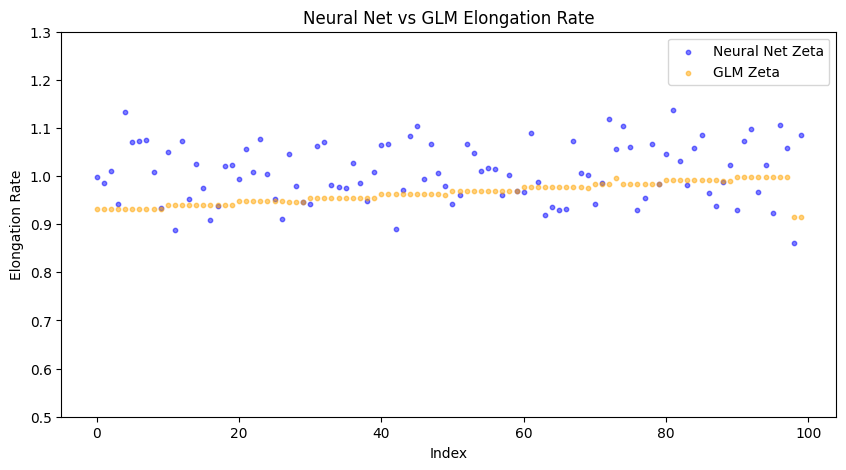

number of samples: 6
tensor([[-0.0045, -0.0459, -0.0077, -0.0568,  0.1098,  0.0374,  0.0676,  0.0742,
         -0.0136, -0.0722,  0.0191, -0.0769,  0.0642, -0.0688,  0.0436, -0.0288,
         -0.0575, -0.0752, -0.0079,  0.0274,  0.0218, -0.0056, -0.0128,  0.0745,
         -0.0091, -0.0585, -0.0968,  0.0349, -0.0119, -0.0753, -0.0460,  0.0984,
          0.0741, -0.0032, -0.0386, -0.0216,  0.0622, -0.0193, -0.0458,  0.0149,
          0.0414,  0.0408, -0.0898, -0.0204,  0.0615,  0.1108, -0.0563,  0.0424,
          0.0285, -0.0172, -0.0766, -0.0042,  0.0456,  0.0418, -0.0092,  0.0355,
          0.0142, -0.0497, -0.0133, -0.0161, -0.0061,  0.0766,  0.0197, -0.0538,
         -0.0629, -0.0969, -0.0862,  0.0476,  0.0437, -0.0177, -0.0588, -0.0247,
          0.0942,  0.0596,  0.0513,  0.0395, -0.0929, -0.0881,  0.0512, -0.0485,
          0.0446,  0.0632,  0.0289, -0.0643,  0.0892,  0.0617, -0.0178, -0.0562,
         -0.0248, -0.0326, -0.0137,  0.0650,  0.0847, -0.0500,  0.0462, -0.0965,
       

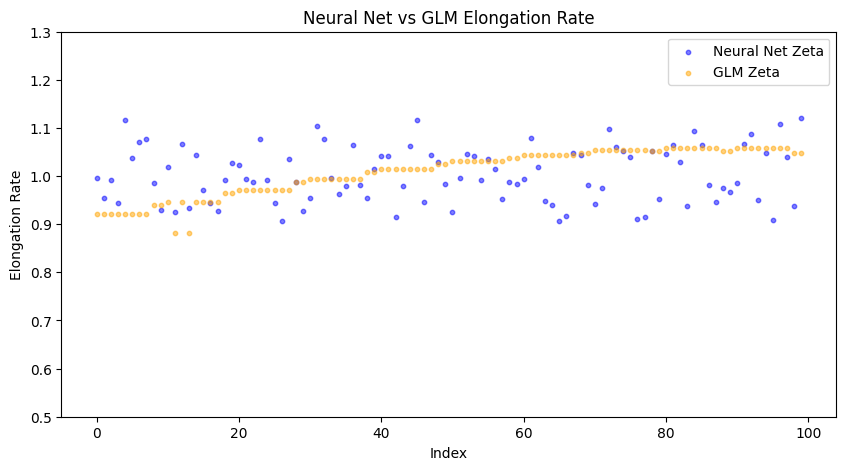

In [84]:
model.eval()

test_dataset = GeneDataset(test_data, True, 100,100)
tstdl = DataLoader(test_dataset, batch_size=1)
data_iter = iter(tstdl)

# plot for subset of genes in test dataset
for i in range(0, 4):
    inputs = next(data_iter) 
    print("number of samples: " + str(len(inputs)))

    with torch.no_grad():
        y_inputs = inputs['Y_ji'].to(device)
        rho_ji = model(y_inputs)
        print(rho_ji)

    glm_zeta = inputs['Z_ji'][0]
    # convert log(Z) outputs to Z
    net_zeta = torch.exp(rho_ji.cpu().squeeze())
    
    plot_data(glm_zeta, net_zeta)

In [ ]:
# compute metrics for test dataset

net_zeta = []
glm_zeta = []
with torch.no_grad():
    for batch in tstdl:
        y_inputs = batch['Y_ji'].to(device)
        rho_ji = model(y_inputs)
        # convert log(Z) outputs to Z
        net_zeta.append(torch.exp(rho_ji.cpu()[0]))
        glm_zeta.append(batch['Z_ji'][0])

net_zeta = torch.cat(net_zeta, dim=0)
glm_zeta = torch.cat(glm_zeta, dim=0)
mae = F.l1_loss(net_zeta.squeeze(), glm_zeta)
mse = F.mse_loss(net_zeta.squeeze(), glm_zeta)

correlation_coefficient = np.corrcoef(glm_zeta, net_zeta.squeeze())[0, 1]
print("Correlation Coefficient:", correlation_coefficient)

print(f"Mean Absolute Error: {mae.item():.4f}")
print(f"Mean Squared Error: {mse.item():.4f}")

In [ ]:
def density_plot(glm_zeta, net_zeta, gene_id):
    sns.kdeplot(x=glm_zeta, y=net_zeta, fill=True, cmap="Blues")
            
    plt.xlim([min(glm_zeta), max(glm_zeta)])
    plt.ylim([min(net_zeta), max(net_zeta)])


    plt.xlabel('GLM Elongation Rate')
    plt.ylabel('Neural Net Elongation Rate')
    plt.title(gene_id)
    plt.show()

In [ ]:
def scatterplot(net_zeta, glm_zeta, gene_id):
    indices = range(len(glm_zeta))
    
    fig, ax = plt.subplots(figsize=(10, 5))
    
    min_val = min(min(net_zeta), min(glm_zeta))
    max_val = max(max(net_zeta), max(glm_zeta))

    plt.xlim(min_val, max_val)
    plt.ylim(min_val, max_val)
    
    ax.scatter(net_zeta, glm_zeta, s=5)
    
    ax.set_title(gene_id)
    ax.set_xlabel('Neural Net Zeta')
    ax.set_ylabel('GLM Zeta')
    ax.legend()

    plt.show()


In [ ]:
# plot for all genes in test dataset

total_loss = 0
loss_fn = CustomLoss()
for batch in tstdl:
    gene_id = batch['GeneId'][0]
    model.eval()

    with torch.no_grad():
        y_inputs = batch['Y_ji'].to(device)
        rho_ji = model(y_inputs)
        loss = loss_fn(batch['X_ji'], batch['C_j'], rho_ji)
    
    total_loss += loss.item()

    glm_zeta = batch['Z_ji'][0]
    # convert log(Z) outputs to Z
    net_zeta = torch.exp(rho_ji.cpu().squeeze())
        
    #density_plot(glm_zeta, net_zeta, gene_id)
        
    #scatterplot(predicted_zeta, simulated_zeta, gene_id)
        
    #plot_data(glm_zeta, net_zeta)

In [ ]:
# plot scatterplot of neural net weights and glm weights

plt.figure(figsize=(10, 10))

sns.scatterplot(x=glm_kappa, y=weights[0])

for i in range(len(glm_kappa)):
    plt.text(glm_kappa[i], weights[0][i], feature_names[i], fontsize=13, ha='right', va='top')
plt.xlabel('GLM Weights')
plt.ylabel('Neural Net Weights')

max_val = max(np.max(glm_kappa), np.max(weights[0])) + 0.04
min_val = min(np.min(glm_kappa), np.min(weights[0])) - 0.04

plt.xlim(max_val, min_val)
plt.ylim(max_val, min_val)

# Show the plot
plt.show()

In [ ]:
# profiling code
"""
def print_profiler_results(profiler):
    print(profiler.key_averages().table(sort_by="self_cpu_time_total", row_limit=10))

with torch.profiler.profile(
    activities=[torch.profiler.ProfilerActivity.CPU, torch.profiler.ProfilerActivity.CUDA],
    schedule=torch.profiler.schedule(wait=1, warmup=1, active=3),
    on_trace_ready=print_profiler_results,
    record_shapes=True,
    profile_memory=True
) as profiler:

    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}')
        model.train()
        trndl = DataLoader(train_set, batch_size=batch_size, num_workers=7, shuffle=False, pin_memory=True)
        for i, batch in enumerate(trndl):
            optimizer.zero_grad()
            Y_ji_batch = batch['Y_ji'].to(device)
            X_ji_batch = batch['X_ji'].to(device)
            C_j_batch = batch['C_j'].to(device)
            outputs = model(Y_ji_batch)
            loss = loss_fn(X_ji_batch, C_j_batch, outputs)
            loss.backward()
            optimizer.step()
            loss_hist_train[epoch] += loss.item()
            profiler.step()
        loss_hist_train[epoch] /= len(trndl)
        del trndl
"""